#  Customer Clustering with ARPU, ATPU and Recency, Frequency


In [66]:
import pandas as pd
import seaborn as sns
import sql_functions as sf
import sklearn
import psycopg2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# table loading from Azure
engine=sf.get_engine()
df=pd.read_sql('select * from capstone.customer_data', engine)


In [5]:
df

,index,customer_id,recency,frequency,avg_cons_per_user,avg_revenue_per_user,recency_scale
0,0,1,-66,3.0,52.00,17.65,-1
1,1,6,-19,1.0,28.00,11.87,-1
2,2,9,-38,1.0,25.00,9.97,-1
3,3,10,89,2.0,17.05,7.64,89
4,4,17,-170,19.0,167.45,53.57,-1
...,...,...,...,...,...,...,...
379724,396008,1032838,-30,1.0,25.00,11.60,-1
379725,396009,1032841,-180,1.0,26.67,10.57,-1
379726,396010,1032845,-30,1.0,180.00,48.00,-1
379727,396011,1032848,-90,1.0,28.00,11.87,-1


In [6]:
# drop the index column
df.drop('index' , axis=1 , inplace=True)


In [7]:
#column rename and round the numbers to two decimal
df.rename(columns={'avg_revenue_per_user': 'ARPU' , 'avg_cons_per_user'	: 'ATPU' } ,  inplace=True)
df=df.round(2)

# 1. sacale the attributes

to have better results we sacle 'ARPU' , 'ATPU' and 'Frequency' using 'qcut' which use the quantiles for scoring 

In [34]:
# scaling
df['ATPU_scale']=pd.qcut(df['ATPU'] , 4 , labels=[1, 2, 3 , 4] )

In [43]:
df['ARPU_scale']=pd.qcut(df['ARPU'] , 4 , labels=[1, 2, 3 , 4] )


In [49]:
df['frequency_scale']=pd.qcut(df['frequency'] , 5 , labels=[1, 2, 3 , 4] , duplicates='drop')

but for recency we use manual segmentation to name different stages of a customer life cycles:
 - Active Customer      recency < -1
 - Edge Customer       recency is 0        rateplans will expires Today 
 - Hibernates         0< recency <15
 - At risk         15< recency <45
 - Lost         recency >45

In [132]:
conditions = [
    (df['recency'] < 0),
    (df['recency'] == 0), 
    (df['recency'] >=1) & (df['recency'] <= 15),
    (df['recency'] >= 16) & (df['recency'] < 45),
    (df['recency'] >= 45)
]

values = [5, 4 , 3 ,2 ,1]

df['recency_score'] = np.select(conditions, values)

print(df)


        customer_id  recency  frequency    ATPU   ARPU  recency_scale  \
0                 1      -66        3.0   52.00  17.65              4   
1                 6      -19        1.0   28.00  11.87              4   
2                 9      -38        1.0   25.00   9.97              4   
3                10       89        2.0   17.05   7.64              4   
4                17     -170       19.0  167.45  53.57              4   
...             ...      ...        ...     ...    ...            ...   
379724      1032838      -30        1.0   25.00  11.60              4   
379725      1032841     -180        1.0   26.67  10.57              4   
379726      1032845      -30        1.0  180.00  48.00              4   
379727      1032848      -90        1.0   28.00  11.87              4   
379728      1032851      -90        1.0   53.33  16.93              4   

        Cluster  Cluster2 ATPU_scale  recency_score ARPU_scale frequency_scale  
0             3         5          3      

In [107]:
#to check the scores
df['recency_score'].nunique()

5

# 2. looking at correlation Heat map

In [110]:
df.iloc[: , 1:5].corr()

,recency,frequency,ATPU,ARPU
recency,1.000000,0.205823,0.041264,0.105209
frequency,0.205823,1.000000,0.453653,0.342178
ATPU,0.041264,0.453653,1.000000,0.730833
ARPU,0.105209,0.342178,0.730833,1.000000


<Axes: >

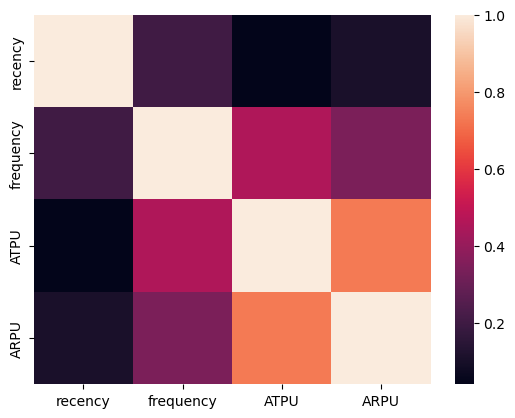

In [112]:
sns.heatmap(df.iloc[: , 1:5].corr())

<Axes: xlabel='ATPU', ylabel='ARPU'>

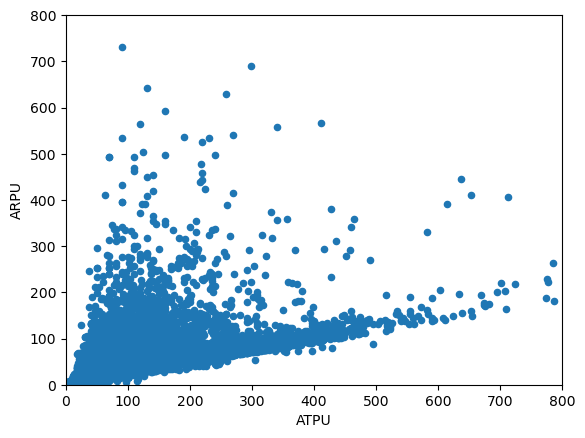

In [113]:
df.plot(kind='scatter' , x='ATPU' , y='ARPU' , xlim=[0 , 800]  ,  ylim=[0 , 800])

although the correlation between ARPU and ATPU is 0.73 but it is better to keep both in the model

# 3. Elbow method  

Elbow with for attribute but not the scores

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

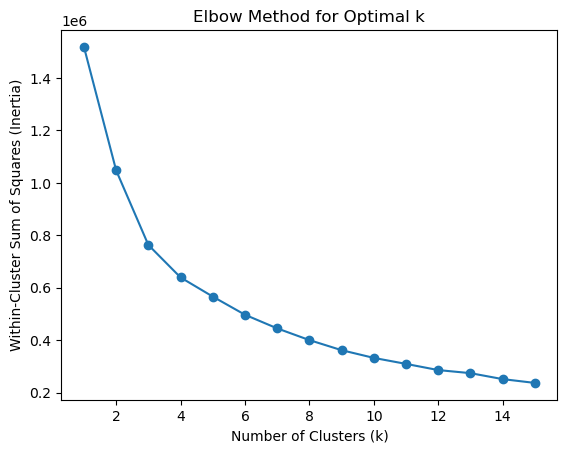

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Select the columns for clustering
columns_for_clustering = ['recency_scale' , 'frequency', 'ARPU' , 'ATPU']
X = df[columns_for_clustering]

# Standardize the data to have mean=0 and standard deviation=1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Calculate the sum of squared distances for different numbers of clusters
inertia = []
max_clusters = 15 

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

It seems that we need to have about 10 Clustemrs!

# 4. Clustering

### we picked 10 as the number of Clusters 

In [12]:
optimal_k = 10  # Set the optimal number of clusters here
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_std)

# The 'Cluster' column now contains the cluster labels for each customer.
print(df)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


        customer_id  recency  frequency    ATPU   ARPU  recency_scale  Cluster
0                 1      -66        3.0   52.00  17.65             -1        2
1                 6      -19        1.0   28.00  11.87             -1        2
2                 9      -38        1.0   25.00   9.97             -1        2
3                10       89        2.0   17.05   7.64             89        4
4                17     -170       19.0  167.45  53.57             -1        0
...             ...      ...        ...     ...    ...            ...      ...
379724      1032838      -30        1.0   25.00  11.60             -1        2
379725      1032841     -180        1.0   26.67  10.57             -1        2
379726      1032845      -30        1.0  180.00  48.00             -1        9
379727      1032848      -90        1.0   28.00  11.87             -1        2
379728      1032851      -90        1.0   53.33  16.93             -1        2

[379729 rows x 7 columns]


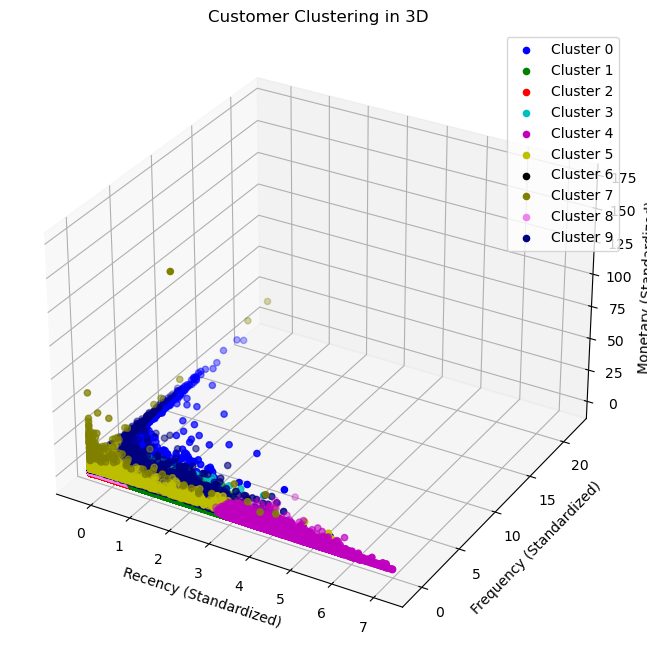

In [102]:
# Plotting the 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a list of colors for each cluster label
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k' , 'olive' , 'violet' , 'navy']

# Plot each data point with the cluster's color
for cluster_label in range(optimal_k):
    ax.scatter(X_std[df['Cluster'] == cluster_label, 0], 
               X_std[df['Cluster'] == cluster_label, 1], 
               X_std[df['Cluster'] == cluster_label, 2], 
               c=colors[cluster_label], label=f'Cluster {cluster_label}')

ax.set_xlabel('Recency (Standardized)')
ax.set_ylabel('Frequency (Standardized)')
ax.set_zlabel('Monetary (Standardized)')
ax.set_title('Customer Clustering in 3D')
ax.legend()

plt.show()

In [161]:
# looking at each clusters Min, Max and mean
df_cluster_profile=df.groupby('Cluster').agg({
    'customer_id': 'count' ,
    'recency_scale' :['min' , 'max' , 'mean' , 'std'] , 
    'frequency' :['min' , 'max' , 'mean' , 'std'] , 
    'ARPU' :['min' , 'max' , 'mean', 'std'], 
    'ATPU' : ['min' , 'max' , 'mean', 'std']}).round(2)
df_cluster_profile

customer_id recency_scale                     frequency               \
              count           min  max    mean    std       min   max   mean   
Cluster                                                                        
0              6391            -1   99   -0.31   4.64      12.0  66.0  16.68   
1             25854            24   84   48.69  15.84       1.0  11.0   2.18   
2            134586            -1   25    0.27   4.33       1.0   4.0   1.73   
3             51258            -1   92    0.66   7.09       2.0  12.0   7.34   
4             12196            76  183  116.33  21.93       1.0  14.0   1.49   
5              3657            -1  147    6.84  17.89       1.0  13.0   2.16   
6             63359            -1   46    0.26   4.34       4.0  15.0   6.39   
7               255            -1  114    5.73  18.41       1.0  77.0   2.40   
8             69207            -1   55    0.34   5.11       1.0   5.0   2.21   
9             12966            -1  147    2.51  13.62       1.0  37.0   8.71   

                 ARPU                             ATPU                   \
          std     min      max    mean     std     min      max    mean   
Cluster                                                                   
0        4.83   13.26   151.61   41.58   12.69   16.57   449.29  115.00   
1        1.38    0.00    64.97   14.46    7.99    0.25   164.00   35.54   
2        0.92    0.00    37.20   12.78    3.90    0.17    68.35   34.27   
3        1.85   20.37    70.63   32.98    6.45   43.20   181.95  104.69   
4        0.88    0.00   106.80   16.79   10.89    0.50   265.00   44.24   
5        1.70   55.30   222.00   91.49   31.57   18.00   398.00  100.82   
6        1.52    4.37    41.96   16.47    5.47    5.14    78.64   40.18   
7        7.28  167.82  2940.00  321.25  204.08   37.00  2179.00  289.94   
8        1.17   12.04    60.98   25.88    7.19   17.20   170.69   77.15   
9        3.66   34.78   176.58   56.31   14.07  117.60   710.45  200.48   

                 
            std  
Cluster          
0         40.21  
1         25.62  
2         14.97  
3         22.66  
4         37.54  
5         44.34  
6         17.83  
7        293.04  
8         17.86  
9         52.80

In [162]:
df.mean()

customer_id      489825.373098
recency             -56.571784
frequency             3.870537
ATPU                 60.829868
ARPU                 21.686630
recency_scale         7.492628
Cluster               4.129677
dtype: float64

In [18]:
df.describe()

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,Cluster,Cluster2
count,3.797290e+05,379729.000000,379729.000000,379729.000000,379729.000000,379729.000000,379729.000000,379729.000000
mean,4.898254e+05,-56.571784,3.870537,60.829868,21.686630,7.492628,4.129677,2.319567
std,3.016831e+05,100.322131,3.350907,44.681471,17.108289,24.587975,2.621208,2.373737
min,1.000000e+00,-1739.000000,1.000000,0.170000,0.000000,-1.000000,0.000000,0.000000
25%,2.204590e+05,-81.000000,1.000000,28.330000,12.100000,-1.000000,2.000000,0.000000
50%,4.624400e+05,-24.000000,3.000000,51.930000,17.790000,-1.000000,3.000000,1.000000
75%,7.167500e+05,-5.000000,6.000000,80.430000,26.660000,-1.000000,6.000000,5.000000
max,1.032851e+06,183.000000,77.000000,2179.000000,2940.000000,183.000000,9.000000,7.000000


<Axes: ylabel='Frequency'>

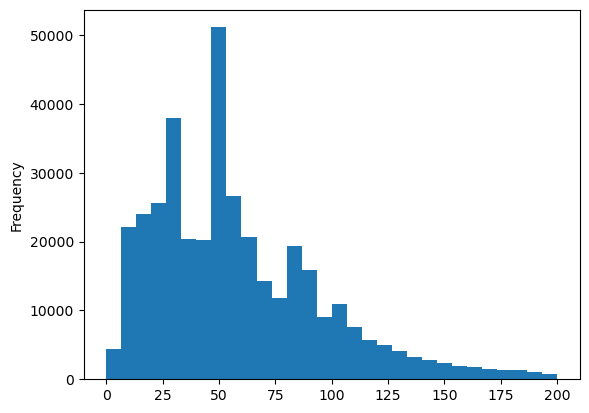

In [28]:
df.ATPU.plot(kind='hist' , range=[0 , 200] , bins=30
             )


In [115]:
def plot_cluster_3d(num):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df[df['Cluster'] == num].frequency , 
               df[df['Cluster'] == num].ARPU , 
               df[df['Cluster'] == num].recency_scale , 
               c='r', label=f'Cluster {num}')

    ax.set_xlabel('Frequency')
    ax.set_ylabel('ARPU')
    ax.set_zlabel('Recency_scale')
    ax.set_title('Customer Clustering in 3D')
    ax.legend()

    plt.show()
    

In [143]:
def plot_cluster_2d(num):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Plot the first scatter plot in the first subplot
    df.plot.scatter(df[df['Cluster']==num]['frequency'] ,df[df['Cluster']==num]['ARPU']  , ax=axes[0])
    axes[0].set_title(f'Cluster {num}')

    # Plot the second scatter plot in the second subplot
    #df.plot.scatter(df[df['Cluster']==num][['recency_scale' , 'ATPU']]  , ax=axes[1])
    #axes[1].set_title(f'Cluster {num}')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

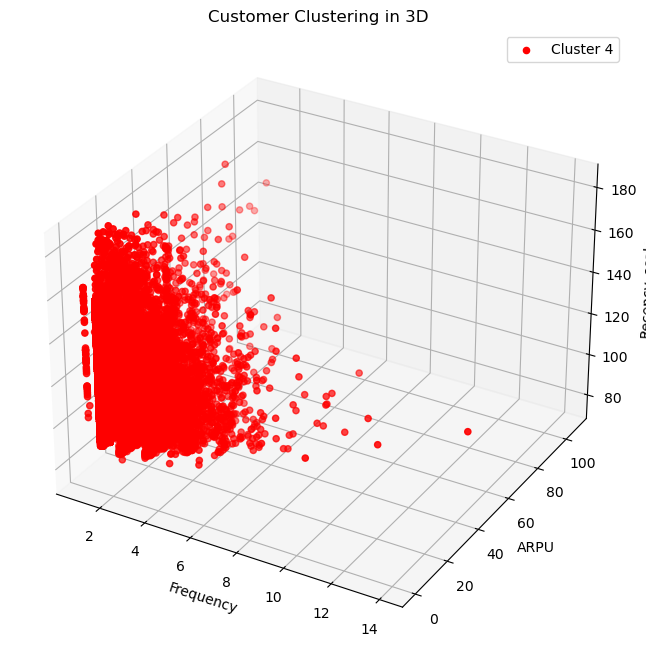

In [118]:
plot_cluster(4)

In [140]:
df[df['Cluster'] == 1]

,frequency,ARPU
7,2.0,31.78
17,1.0,11.43
40,2.0,6.38
44,1.0,46.97
54,1.0,8.40
...,...,...
373793,1.0,13.60
374610,1.0,14.40
375278,1.0,20.93
375809,1.0,25.20


### interperting the Clusters wasn't successful so we decide to reduce the number of clusters

In [14]:
optimal_k = 8  # Set the optimal number of clusters here
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster2'] = kmeans.fit_predict(X_std)

# The 'Cluster2' column now contains the cluster labels for each customer.
print(df)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


        customer_id  recency  frequency    ATPU   ARPU  recency_scale  \
0                 1      -66        3.0   52.00  17.65             -1   
1                 6      -19        1.0   28.00  11.87             -1   
2                 9      -38        1.0   25.00   9.97             -1   
3                10       89        2.0   17.05   7.64             89   
4                17     -170       19.0  167.45  53.57             -1   
...             ...      ...        ...     ...    ...            ...   
379724      1032838      -30        1.0   25.00  11.60             -1   
379725      1032841     -180        1.0   26.67  10.57             -1   
379726      1032845      -30        1.0  180.00  48.00             -1   
379727      1032848      -90        1.0   28.00  11.87             -1   
379728      1032851      -90        1.0   53.33  16.93             -1   

        Cluster  Cluster2  
0             2         0  
1             2         0  
2             2         0  
3          

In [15]:
# looking at each clusters Min, Max and mean
df_cluster_profile=df.groupby('Cluster2').agg({
    'customer_id': 'count' ,
    'recency_scale' :['min' , 'max' , 'mean' , 'std'] , 
    'frequency' :['min' , 'max' , 'mean' , 'std'] , 
    'ARPU' :['min' , 'max' , 'mean', 'std'], 
    'ATPU' : ['min' , 'max' , 'mean', 'std']}).round(2)
df_cluster_profile

customer_id recency_scale                     frequency              \
               count           min  max    mean    std       min   max  mean   
Cluster2                                                                       
0             141869            -1   25    0.22   4.22       1.0   4.0  1.72   
1              51662            -1   78    0.28   6.15       4.0  39.0  8.35   
2              12286            75  183  116.13  22.01       1.0  14.0  1.50   
3              66038            -1   74    0.84   6.54       1.0   5.0  2.37   
4                453            -1  144    7.21  21.09       1.0  77.0  2.15   
5              65796            -1   46    0.28   4.36       4.0  17.0  6.23   
6              15708            -1  147    2.39  13.19       1.0  66.0  9.71   
7              25917            24   84   48.54  15.85       1.0  11.0  2.18   

                  ARPU                            ATPU                   \
           std     min      max    mean     std    min      max    mean   
Cluster2                                                                  
0         0.89    0.00    38.05   13.17    4.16   0.17    71.96   35.82   
1         2.75   14.72    92.74   33.07    6.67  22.50   167.60  103.69   
2         0.89    0.00   155.20   16.99   11.55   0.50   265.00   44.54   
3         1.29   13.97   116.97   28.90   10.82  17.20   192.91   82.33   
4         5.83  147.50  2940.00  259.66  168.56  37.00  2179.00  238.44   
5         1.48    4.37    43.37   16.54    5.48   5.14    84.27   40.57   
6         5.87   37.47   171.28   61.15   20.49  25.00   612.00  189.73   
7         1.39    0.00    83.47   14.44    8.06   0.25   157.89   35.43   

                  
             std  
Cluster2          
0          15.87  
1          23.76  
2          37.95  
3          20.05  
4         243.83  
5          17.96  
6          55.04  
7          25.55

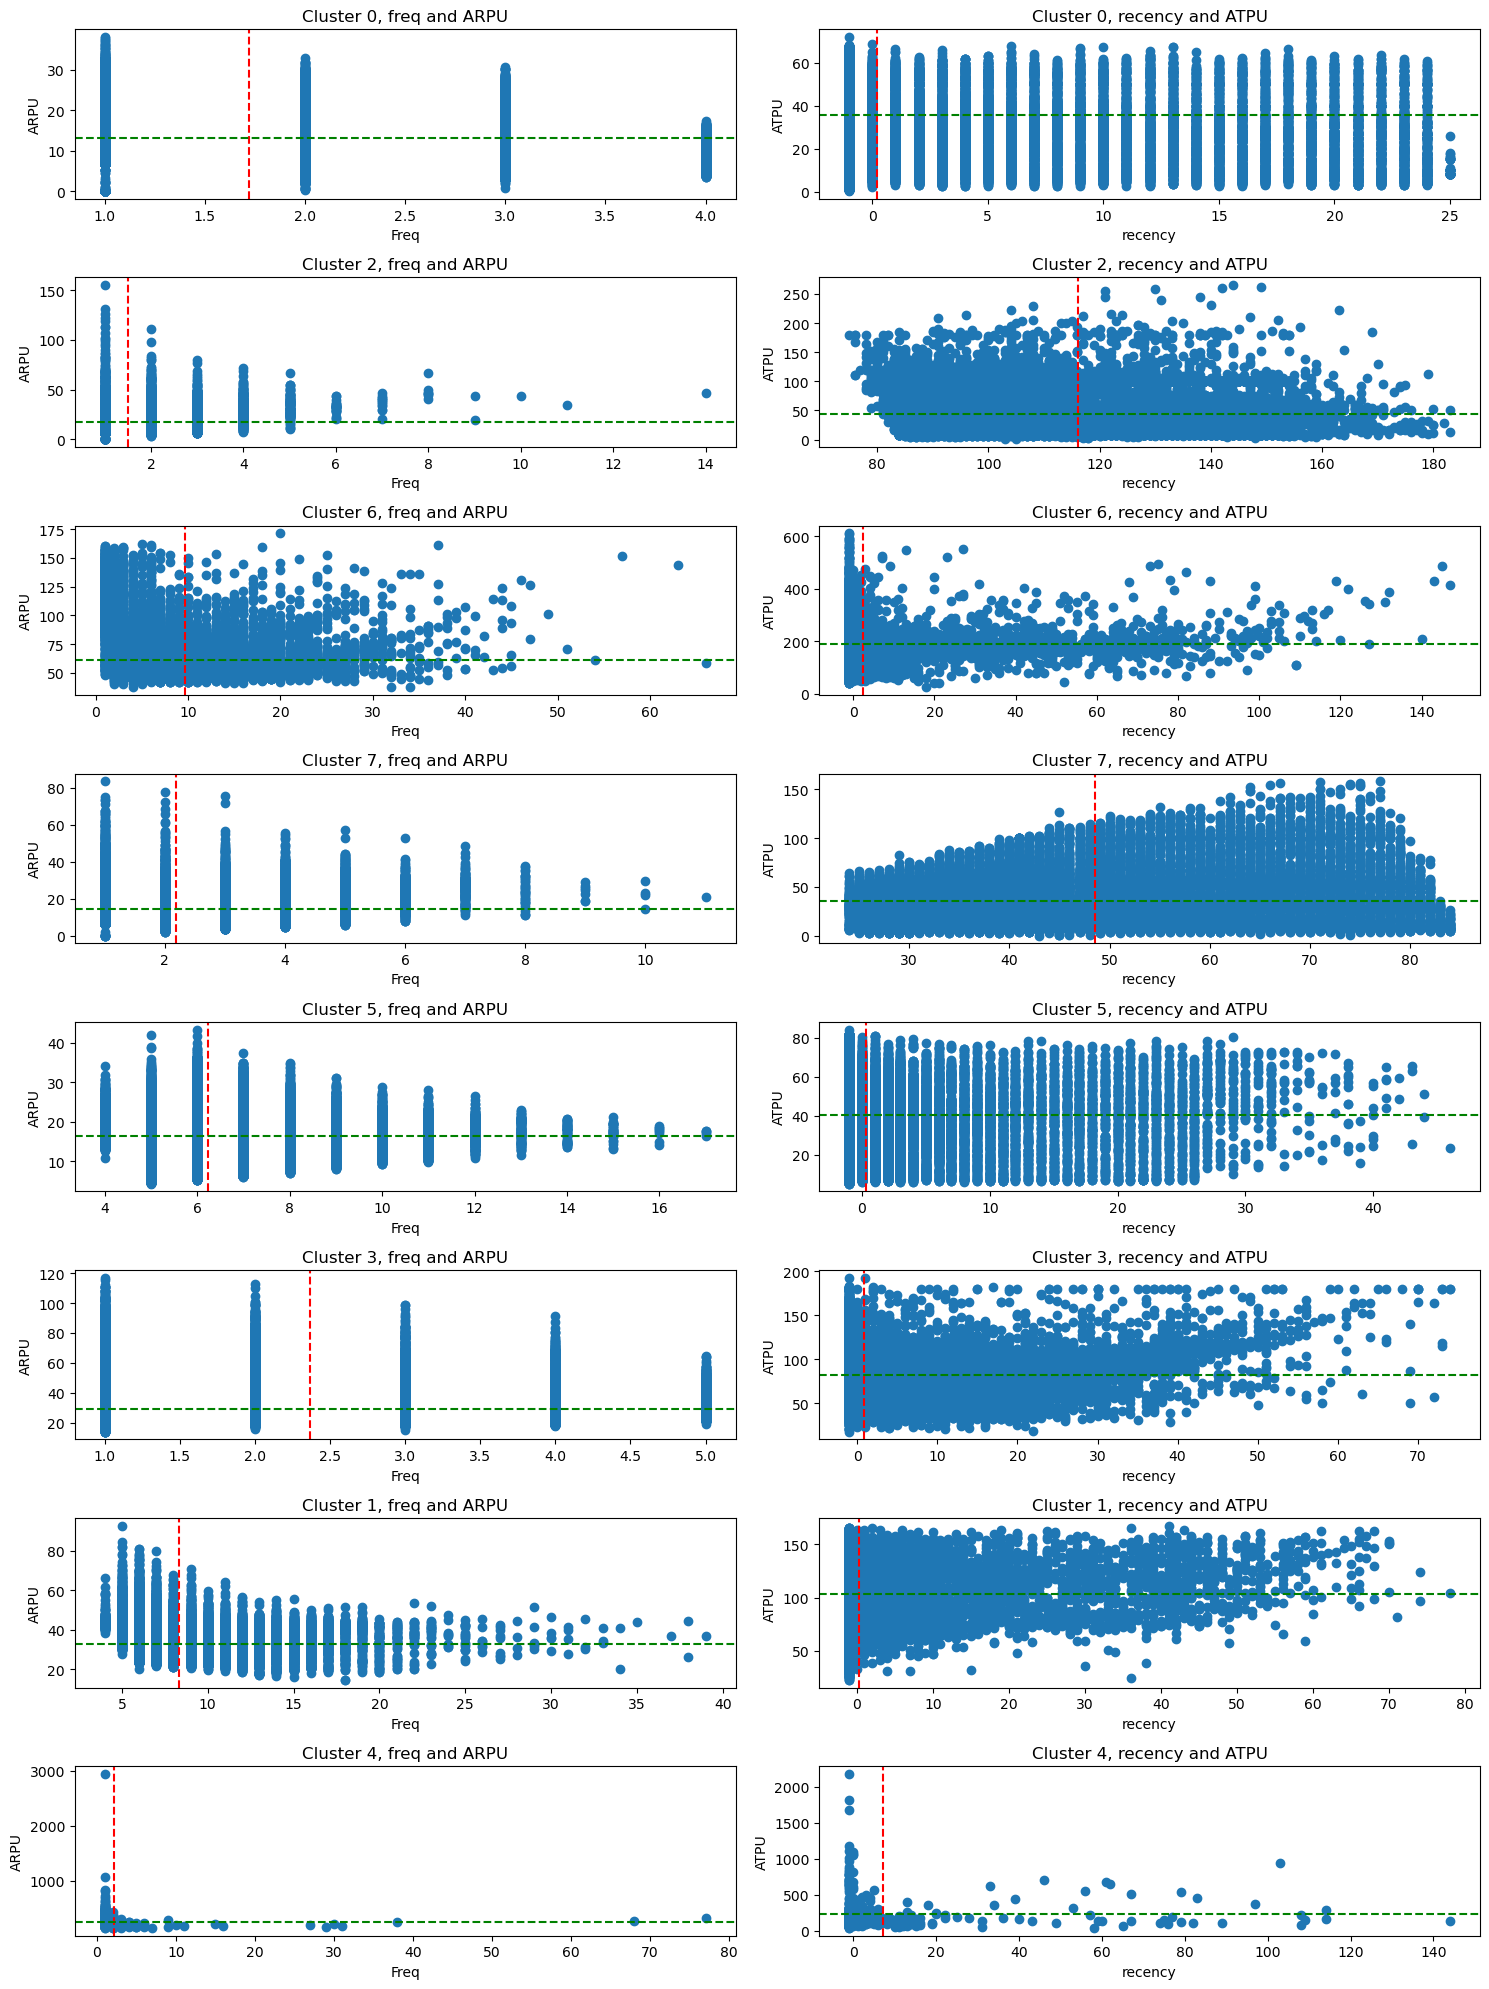

In [16]:

# Get unique cluster labels
unique_clusters = df['Cluster2'].unique()

# Create a figure and an array of subplots
num_clusters = len(unique_clusters)
num_attributes = 2  # Number of attribute pairs to plot in each row
num_rows = num_clusters
num_cols = num_attributes

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 20))

# Iterate over unique clusters and plot scatter plots
for i, cluster_label in enumerate(unique_clusters):
    cluster_data = df[df['Cluster2'] == cluster_label]
    scatter_ax1 = axes[i, 0]
    scatter_ax2 = axes[i, 1]
    

    
    # Plot the scatter plot for attributes 1 and 2
    scatter_ax1.scatter(cluster_data['frequency'], cluster_data['ARPU'])
    scatter_ax1.axvline(cluster_data['frequency'].mean(), color='r', linestyle='dashed', label='Avg frequency 1')
    scatter_ax1.axhline(cluster_data['ARPU'].mean(), color='g', linestyle='dashed', label='Avg ARPU')
    scatter_ax1.set_title(f'Cluster {cluster_label}, freq and ARPU')
    scatter_ax1.set_xlabel('Freq')
    scatter_ax1.set_ylabel('ARPU')
    
    # Plot the scatter plot for attributes 3 and 4
    scatter_ax2.scatter(cluster_data['recency_scale'], cluster_data['ATPU'])
    scatter_ax2.axvline(cluster_data['recency_scale'].mean(), color='r', linestyle='dashed', label='Avg recency_scale')
    scatter_ax2.axhline(cluster_data['ATPU'].mean(), color='g', linestyle='dashed', label='Avg ATPU')
    scatter_ax2.set_title(f'Cluster {cluster_label}, recency and ATPU')
    scatter_ax2.set_xlabel('recency')
    scatter_ax2.set_ylabel('ATPU')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


unable to lable the clusters

# 5. Clustering based on scores
 First elbow method for the scores

In [50]:
df

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,Cluster,Cluster2,ATPU_scale,recency_score,ARPU_scale,frequency_scale
0,1,-66,3.0,52.00,17.65,4,2,0,3,5,2,2
1,6,-19,1.0,28.00,11.87,4,2,0,1,5,1,1
2,9,-38,1.0,25.00,9.97,4,2,0,1,5,1,1
3,10,89,2.0,17.05,7.64,4,4,2,1,5,1,1
4,17,-170,19.0,167.45,53.57,4,0,6,4,5,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
379724,1032838,-30,1.0,25.00,11.60,4,2,0,1,5,1,1
379725,1032841,-180,1.0,26.67,10.57,4,2,0,1,5,1,1
379726,1032845,-30,1.0,180.00,48.00,4,9,3,4,5,4,1
379727,1032848,-90,1.0,28.00,11.87,4,2,0,1,5,1,1


/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

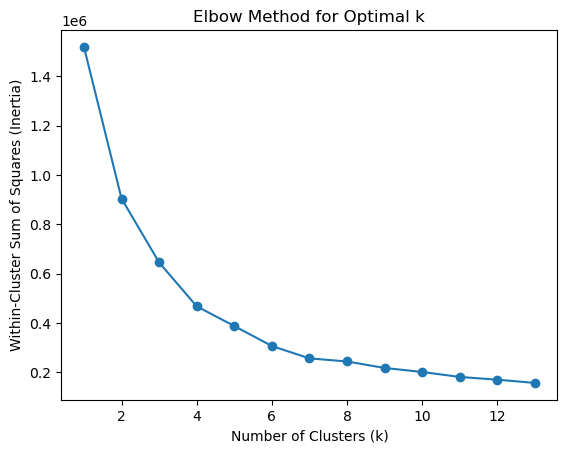

In [69]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Select the columns for clustering
columns_for_clustering = ['recency_score' , 'frequency_scale', 'ARPU_scale' , 'ATPU_scale']
X = df[columns_for_clustering]

# Standardize the data to have mean=0 and standard deviation=1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Calculate the sum of squared distances for different numbers of clusters
inertia = []
max_clusters = 13 

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [70]:
optimal_k = 10  # Set the optimal number of clusters here
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_std)

# The 'Cluster' column now contains the cluster labels for each customer.
print(df)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


        customer_id  recency  frequency    ATPU   ARPU  recency_scale  \
0                 1      -66        3.0   52.00  17.65              4   
1                 6      -19        1.0   28.00  11.87              4   
2                 9      -38        1.0   25.00   9.97              4   
3                10       89        2.0   17.05   7.64              4   
4                17     -170       19.0  167.45  53.57              4   
...             ...      ...        ...     ...    ...            ...   
379724      1032838      -30        1.0   25.00  11.60              4   
379725      1032841     -180        1.0   26.67  10.57              4   
379726      1032845      -30        1.0  180.00  48.00              4   
379727      1032848      -90        1.0   28.00  11.87              4   
379728      1032851      -90        1.0   53.33  16.93              4   

        Cluster  Cluster2 ATPU_scale  recency_score ARPU_scale frequency_scale  
0             3         0          3      

In [71]:
# looking at each clusters Min, Max and mean
df_cluster_profile=df.groupby('Cluster').agg({
    'customer_id': 'count' ,
    'recency_score' :['min' , 'max' , 'mean' , 'std'] , 
    'frequency' :['min' , 'max' , 'mean' , 'std'] , 
    'ARPU' :['min' , 'max' , 'mean', 'std'], 
    'ATPU' : ['min' , 'max' , 'mean', 'std']}).round(2)
df_cluster_profile

customer_id recency_score                 frequency                    \
              count           min max  mean   std       min   max  mean   std   
Cluster                                                                         
0             58419             4   5  4.97  0.17       1.0   4.0  1.99  0.99   
1             46794             4   5  4.99  0.12       1.0   2.0  1.29  0.45   
2             34923             3   5  4.87  0.46       5.0  39.0  7.39  1.99   
3             66096             4   5  4.98  0.13       1.0   4.0  1.81  0.97   
4             24808             4   5  4.93  0.25       3.0   6.0  5.06  1.10   
5             20857             0   3  1.84  0.84       1.0  17.0  1.94  1.26   
6             18315             0   3  1.96  0.86       1.0  35.0  3.75  2.34   
7             37970             3   5  4.83  0.52       3.0  18.0  5.21  1.49   
8             43902             3   5  4.90  0.39       7.0  77.0  9.82  3.80   
9             27645             0   3  1.73  0.76       1.0  12.0  1.88  1.18   

          ARPU                          ATPU                          
           min      max   mean    std    min      max    mean    std  
Cluster                                                               
0        13.97  1066.40  27.70  22.29  28.36  2179.00   77.39  29.88  
1         0.00    17.79   9.76   1.97   0.17    50.00   22.68   6.80  
2        12.11    92.74  20.77   3.44  22.50    80.43   55.29  12.88  
3         9.11    69.64  15.85   2.27  11.14    80.00   47.37   8.52  
4        18.97   318.26  36.01  13.94  52.05   653.60  111.66  39.65  
5         4.67   294.97  19.16   8.52  15.29   116.67   45.35  10.95  
6        15.03  2940.00  38.12  34.82  28.48   945.45   95.50  45.48  
7         0.80    24.45  10.92   3.51   3.24    56.83   23.34  12.09  
8        22.06   322.08  39.61  13.17  51.95  1175.49  128.83  49.21  
9         0.00    17.79   8.76   2.89   0.25    50.00   16.19   8.88

agian the Cluster doesn't make sense!!

# 5. Dimention Reduction
we decide to reduce the 'recency' from the ML clustering and do it later manually. so we just do the clustering for active customers (customers with active rate plan)

In [95]:
#define a dataframe with just active customers
df_actives=df[df['recency_score']==5]

In [96]:
df_actives

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,Cluster,Cluster2,ATPU_scale,recency_score,ARPU_scale,frequency_scale
0,1,-66,3.0,52.00,17.65,4,3,5,3,5,2,2
1,6,-19,1.0,28.00,11.87,4,1,3,1,5,1,1
2,9,-38,1.0,25.00,9.97,4,1,3,1,5,1,1
4,17,-170,19.0,167.45,53.57,4,8,4,4,5,4,4
5,29,-258,1.0,50.96,14.61,4,3,5,2,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
379724,1032838,-30,1.0,25.00,11.60,4,1,3,1,5,1,1
379725,1032841,-180,1.0,26.67,10.57,4,1,3,1,5,1,1
379726,1032845,-30,1.0,180.00,48.00,4,0,2,4,5,4,1
379727,1032848,-90,1.0,28.00,11.87,4,1,3,1,5,1,1


In [164]:

# Select the columns for clustering
columns_for_clustering = ['recency' , 'frequency', 'ARPU' , 'ATPU']
X = df_actives[columns_for_clustering]

# Standardize the data to have mean=0 and standard deviation=1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

optimal_k = 6  # Set the optimal number of clusters here
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_actives['Cluster2'] = kmeans.fit_predict(X_std)
# looking at each clusters Min, Max and mean
df_cluster_profile=df_actives.groupby('Cluster2').agg({
    'customer_id': 'count' ,
    'recency' : ['min' , 'max' , 'mean' , 'std'] ,
    'frequency' :['min' , 'max' , 'mean' , 'std'] , 
    'ARPU' :['min' , 'max' , 'mean', 'std'], 
    'ATPU' : ['min' , 'max' , 'mean', 'std']}).round(2)
df_cluster_profile

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/rm/41cjyqnx1vx4606hvq4_ml_w0000gn/T/ipykernel_51901/3200606980.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actives['Cluster2'] = kmeans.fit_predict(X_std)


customer_id recency                     frequency                     \
               count     min  max    mean    std       min   max   mean   std   
Cluster2                                                                        
0              59465    -365   -1  -37.23  39.28       1.0  20.0   6.51  2.77   
1             116321    -167   -1  -58.53  42.12       1.0   5.0   1.89  0.93   
2                315    -333   -1  -25.77  32.13       1.0  77.0   3.19  7.63   
3              16499    -365   -1  -28.78  38.38       1.0  66.0  11.13  5.57   
4              53401    -362   -1  -24.57  26.94       4.0  27.0   6.48  1.81   
5              51771   -1739 -160 -266.71  64.48       1.0  18.0   1.69  1.54   

            ARPU                            ATPU                           
             min      max    mean     std    min      max    mean     std  
Cluster2                                                                   
0          18.97   110.90   32.90    8.06  20.00   193.00  100.93   22.19  
1           0.00    58.57   16.27    5.90   0.17   110.00   46.23   20.57  
2         126.03  1066.40  237.01  116.08  38.00  2179.00  263.21  268.28  
3          20.28   151.61   54.60   16.41  32.66   522.78  176.75   52.49  
4           3.41    35.83   15.61    5.55   4.24    77.32   38.08   18.56  
5           0.00    82.18   15.65    6.67   0.82   194.00   49.89   26.49

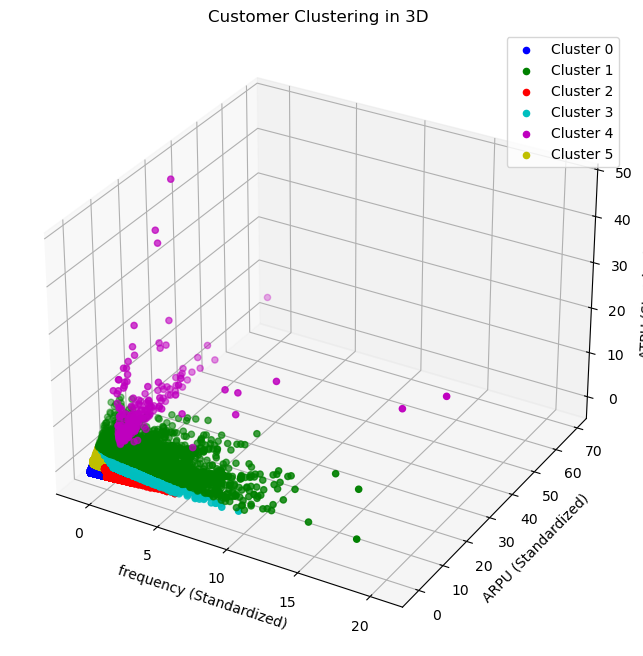

In [127]:
# Plotting the 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a list of colors for each cluster label
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot each data point with the cluster's color
for cluster_label in range(optimal_k):
    ax.scatter(X_std[df_actives['Cluster'] == cluster_label, 0], 
               X_std[df_actives['Cluster'] == cluster_label, 1], 
               X_std[df_actives['Cluster'] == cluster_label, 2], 
               c=colors[cluster_label], label=f'Cluster {cluster_label}')

ax.set_xlabel('frequency (Standardized)')
ax.set_ylabel('ARPU (Standardized)')
ax.set_zlabel('ATPU (Standardized)')
ax.set_title('Customer Clustering in 3D')
ax.legend()

In [128]:
df_actives


,customer_id,recency,frequency,ATPU,ARPU,recency_scale,Cluster,ATPU_scale,recency_score,ARPU_scale,frequency_scale
0,1,-66,3.0,52.00,17.65,4,0,3,5,2,2
1,6,-19,1.0,28.00,11.87,4,0,1,5,1,1
2,9,-38,1.0,25.00,9.97,4,0,1,5,1,1
4,17,-170,19.0,167.45,53.57,4,1,4,5,4,4
5,29,-258,1.0,50.96,14.61,4,0,2,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...
379724,1032838,-30,1.0,25.00,11.60,4,0,1,5,1,1
379725,1032841,-180,1.0,26.67,10.57,4,0,1,5,1,1
379726,1032845,-30,1.0,180.00,48.00,4,5,4,5,4,1
379727,1032848,-90,1.0,28.00,11.87,4,0,1,5,1,1


In [119]:
df_actives.drop("Cluster2" , axis=1 , inplace=True)
df_actives


/var/folders/rm/41cjyqnx1vx4606hvq4_ml_w0000gn/T/ipykernel_51901/669175746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actives.drop("Cluster3" , axis=1 , inplace=True)


,customer_id,recency,frequency,ATPU,ARPU,recency_scale,Cluster,ATPU_scale,recency_score,ARPU_scale,frequency_scale
0,1,-66,3.0,52.00,17.65,4,0,3,5,2,2
1,6,-19,1.0,28.00,11.87,4,0,1,5,1,1
2,9,-38,1.0,25.00,9.97,4,0,1,5,1,1
4,17,-170,19.0,167.45,53.57,4,1,4,5,4,4
5,29,-258,1.0,50.96,14.61,4,0,2,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...
379724,1032838,-30,1.0,25.00,11.60,4,0,1,5,1,1
379725,1032841,-180,1.0,26.67,10.57,4,0,1,5,1,1
379726,1032845,-30,1.0,180.00,48.00,4,5,4,5,4,1
379727,1032848,-90,1.0,28.00,11.87,4,0,1,5,1,1


In [129]:
# adjustment
# because of the low number of cluster 4, will merge in cluster 1 which is moore likely
df_actives['Cluster']=df_actives['Cluster'].replace(4 , 1)
df_actives['Cluster']=df_actives['Cluster'].replace(5 , 4)

/var/folders/rm/41cjyqnx1vx4606hvq4_ml_w0000gn/T/ipykernel_51901/3467026936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actives['Cluster']=df_actives['Cluster'].replace(4 , 1)
/var/folders/rm/41cjyqnx1vx4606hvq4_ml_w0000gn/T/ipykernel_51901/3467026936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actives['Cluster']=df_actives['Cluster'].replace(5 , 4)


In [130]:
#chack final profile of clusters

df_cluster_profile=df_actives.groupby('Cluster').agg({
    'customer_id': 'count' ,
    'frequency' :['min' , 'max' , 'mean' , 'std'] , 
    'ARPU' :['min' , 'max' , 'mean', 'std'], 
    'ATPU' : ['min' , 'max' , 'mean', 'std']}).round(2)
df_cluster_profile

customer_id frequency                      ARPU                  \
              count       min   max   mean   std    min      max   mean   
Cluster                                                                   
0            121473       1.0   4.0   1.73  0.92   0.00    33.62  12.91   
1             13638       1.0  77.0  10.49  6.10  33.55  1066.40  62.49   
2             53405       4.0  22.0   6.54  1.58   4.37    37.33  16.36   
3             46865       2.0  38.0   8.14  2.70  19.26    87.92  33.09   
4             62391       1.0   5.0   2.26  1.23  13.97   103.60  26.02   

                 ATPU                          
           std    min      max    mean    std  
Cluster                                        
0         3.69   0.17    71.96   35.62  14.80  
1        36.10  38.00  2179.00  189.75  66.22  
2         5.37   5.14    84.27   40.98  18.44  
3         6.32  28.69   192.91  105.68  23.26  
4         8.08  17.20   183.33   79.18  17.90

In [133]:
df.groupby('recency_score').count()

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,Cluster,Cluster2,ATPU_scale,ARPU_scale,frequency_scale
recency_score,,,,,,,,,,,
1,26566,26566,26566,26566,26566,26566,26566,26566,26566,26566,26566
2,22656,22656,22656,22656,22656,22656,22656,22656,22656,22656,22656
3,27392,27392,27392,27392,27392,27392,27392,27392,27392,27392,27392
4,5343,5343,5343,5343,5343,5343,5343,5343,5343,5343,5343
5,297772,297772,297772,297772,297772,297772,297772,297772,297772,297772,297772


# 6. labeling



In [ ]:
# drop previous clusters in main df
df.drop(['Cluster' , 'Cluster2'] , axis=1 , inplace=True)






In [141]:
# drop all columns of df_actives and just keep the cluster
df_actives_clusters=df_actives[['customer_id' , 'Cluster']]

In [154]:
df


,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale
0,1,-66,3.0,52.00,17.65,4,3,5,2,2
1,6,-19,1.0,28.00,11.87,4,1,5,1,1
2,9,-38,1.0,25.00,9.97,4,1,5,1,1
3,10,89,2.0,17.05,7.64,4,1,1,1,1
4,17,-170,19.0,167.45,53.57,4,4,5,4,4
...,...,...,...,...,...,...,...,...,...,...
379724,1032838,-30,1.0,25.00,11.60,4,1,5,1,1
379725,1032841,-180,1.0,26.67,10.57,4,1,5,1,1
379726,1032845,-30,1.0,180.00,48.00,4,4,5,4,1
379727,1032848,-90,1.0,28.00,11.87,4,1,5,1,1


In [147]:
df_actives_clusters

,customer_id,Cluster
0,1,0
1,6,0
2,9,0
4,17,1
5,29,0
...,...,...
379724,1032838,0
379725,1032841,0
379726,1032845,4
379727,1032848,0


In [185]:
df_final= df.join( df_actives_clusters.set_index('customer_id') , how='left' , on='customer_id')


In [186]:
df_final

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Cluster
0,1,-66,3.0,52.00,17.65,4,3,5,2,2,0.0
1,6,-19,1.0,28.00,11.87,4,1,5,1,1,0.0
2,9,-38,1.0,25.00,9.97,4,1,5,1,1,0.0
3,10,89,2.0,17.05,7.64,4,1,1,1,1,NaN
4,17,-170,19.0,167.45,53.57,4,4,5,4,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...
379724,1032838,-30,1.0,25.00,11.60,4,1,5,1,1,0.0
379725,1032841,-180,1.0,26.67,10.57,4,1,5,1,1,0.0
379726,1032845,-30,1.0,180.00,48.00,4,4,5,4,1,4.0
379727,1032848,-90,1.0,28.00,11.87,4,1,5,1,1,0.0


In [187]:
# Corresponding values for the recency score of inactives

def update_cluster(row):
    if row['recency_score'] == 4:
        return 5
    elif row['recency_score'] == 3:
        return 6
    elif row['recency_score'] == 2:
        return 7
    elif row['recency_score'] == 1:
        return 8
    else:
        return row['Cluster']

# Apply the custom function to each row
df_final['Cluster'] = df_final.apply(update_cluster, axis=1)




In [188]:
#chech the counts
df_final.groupby('Cluster').count()

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale
Cluster,,,,,,,,,,
0.0,121473,121473,121473,121473,121473,121473,121473,121473,121473,121473
1.0,13638,13638,13638,13638,13638,13638,13638,13638,13638,13638
2.0,53405,53405,53405,53405,53405,53405,53405,53405,53405,53405
3.0,46865,46865,46865,46865,46865,46865,46865,46865,46865,46865
4.0,62391,62391,62391,62391,62391,62391,62391,62391,62391,62391
5.0,5343,5343,5343,5343,5343,5343,5343,5343,5343,5343
6.0,27392,27392,27392,27392,27392,27392,27392,27392,27392,27392
7.0,22656,22656,22656,22656,22656,22656,22656,22656,22656,22656
8.0,26566,26566,26566,26566,26566,26566,26566,26566,26566,26566


In [189]:
#final lables
lable_map={
    0 : 'Slippery',              #low frequency, low ARPU , Low ATPU
    1 : 'Heros' ,                    #hign frequency , High ARPU, Hi ATPU
    2 : 'Core' ,                     # monthly buyer , mean ARPU and ATPU
    3 : 'Loyal Gig burners' ,        # high and medium Frequent, repectivly high ARPU and ATPU
    4 : 'Bulk Buyers' ,              #low frequent, mean ARPU, High ATPU
    5 : 'Edge',
    6 : 'Hibernate',
    7 : 'At Risk',
    8 : 'Lost'
} 
df_final['Label']=df_final['Cluster'].map(lable_map)
df_final

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Cluster,Label
0,1,-66,3.0,52.00,17.65,4,3,5,2,2,0.0,Slippery
1,6,-19,1.0,28.00,11.87,4,1,5,1,1,0.0,Slippery
2,9,-38,1.0,25.00,9.97,4,1,5,1,1,0.0,Slippery
3,10,89,2.0,17.05,7.64,4,1,1,1,1,8.0,Lost
4,17,-170,19.0,167.45,53.57,4,4,5,4,4,1.0,Heros
...,...,...,...,...,...,...,...,...,...,...,...,...
379724,1032838,-30,1.0,25.00,11.60,4,1,5,1,1,0.0,Slippery
379725,1032841,-180,1.0,26.67,10.57,4,1,5,1,1,0.0,Slippery
379726,1032845,-30,1.0,180.00,48.00,4,4,5,4,1,4.0,Bulk Buyers
379727,1032848,-90,1.0,28.00,11.87,4,1,5,1,1,0.0,Slippery


In [162]:
conn=sf.get_engine()
table_name='Customer_segments'
Schema_name='capstone'
df_final.to_sql(table_name, conn, schema=Schema_name , if_exists='replace', index=False )

729

In [206]:
df_final

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Cluster,Label
0,1,-66,3.0,52.00,17.65,4,3,5,2,2,0.0,Slippery
1,6,-19,1.0,28.00,11.87,4,1,5,1,1,0.0,Slippery
2,9,-38,1.0,25.00,9.97,4,1,5,1,1,0.0,Slippery
3,10,89,2.0,17.05,7.64,4,1,1,1,1,8.0,Lost
4,17,-170,19.0,167.45,53.57,4,4,5,4,4,1.0,Heros
...,...,...,...,...,...,...,...,...,...,...,...,...
379724,1032838,-30,1.0,25.00,11.60,4,1,5,1,1,0.0,Slippery
379725,1032841,-180,1.0,26.67,10.57,4,1,5,1,1,0.0,Slippery
379726,1032845,-30,1.0,180.00,48.00,4,4,5,4,1,4.0,Bulk Buyers
379727,1032848,-90,1.0,28.00,11.87,4,1,5,1,1,0.0,Slippery


In [207]:
df_final.groupby('Cluster').count()

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Label
Cluster,,,,,,,,,,,
0.0,121473,121473,121473,121473,121473,121473,121473,121473,121473,121473,121473
1.0,13638,13638,13638,13638,13638,13638,13638,13638,13638,13638,13638
2.0,53405,53405,53405,53405,53405,53405,53405,53405,53405,53405,53405
3.0,46865,46865,46865,46865,46865,46865,46865,46865,46865,46865,46865
4.0,62391,62391,62391,62391,62391,62391,62391,62391,62391,62391,62391
5.0,5343,5343,5343,5343,5343,5343,5343,5343,5343,5343,5343
6.0,27392,27392,27392,27392,27392,27392,27392,27392,27392,27392,27392
7.0,22656,22656,22656,22656,22656,22656,22656,22656,22656,22656,22656
8.0,26566,26566,26566,26566,26566,26566,26566,26566,26566,26566,26566


In [208]:
df_slippery=df_final.query('Cluster == 0')
df_slippery

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Cluster,Label
0,1,-66,3.0,52.00,17.65,4,3,5,2,2,0.0,Slippery
1,6,-19,1.0,28.00,11.87,4,1,5,1,1,0.0,Slippery
2,9,-38,1.0,25.00,9.97,4,1,5,1,1,0.0,Slippery
5,29,-258,1.0,50.96,14.61,4,2,5,2,1,0.0,Slippery
6,33,-28,3.0,12.91,6.24,4,1,5,1,2,0.0,Slippery
...,...,...,...,...,...,...,...,...,...,...,...,...
379722,1032819,-30,1.0,50.00,17.80,4,2,5,3,1,0.0,Slippery
379724,1032838,-30,1.0,25.00,11.60,4,1,5,1,1,0.0,Slippery
379725,1032841,-180,1.0,26.67,10.57,4,1,5,1,1,0.0,Slippery
379727,1032848,-90,1.0,28.00,11.87,4,1,5,1,1,0.0,Slippery


In [209]:

# Select the columns for clustering
columns_for_clustering = ['recency' , 'ARPU' , 'ATPU']
X = df_slippery[columns_for_clustering]

# Standardize the data to have mean=0 and standard deviation=1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

optimal_k = 4  # Set the optimal number of clusters here
kmeans = KMeans(n_clusters=optimal_k, random_state=42 , init='k-means++')
df_slippery['Cluster2'] = kmeans.fit_predict(X_std)
# looking at each clusters Min, Max and mean
df_cluster_profile=df_slippery.groupby('Cluster2').agg({
    'customer_id': 'count' ,
    'recency' : ['min' , 'max' , 'mean' , 'std'] ,
    'frequency' :['min' , 'max' , 'mean' , 'std'] , 
    'ARPU' :['min' , 'max' , 'mean', 'std'], 
    'ATPU' : ['min' , 'max' , 'mean', 'std']}).round(2)
df_cluster_profile

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/rm/41cjyqnx1vx4606hvq4_ml_w0000gn/T/ipykernel_51901/1995500902.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slippery['Cluster2'] = kmeans.fit_predict(X_std)


customer_id recency                     frequency                   \
               count     min  max    mean    std       min  max  mean   std   
Cluster2                                                                      
0              41033    -180   -1  -56.06  39.94       1.0  4.0  1.83  0.87   
1              47826    -189   -1  -55.75  47.55       1.0  4.0  1.90  1.00   
2              18426    -365 -144 -256.29  61.02       1.0  4.0  1.41  0.80   
3              14188   -1739 -157 -287.31  60.32       1.0  4.0  1.26  0.63   

           ARPU                       ATPU                      
            min    max   mean   std    min    max   mean   std  
Cluster2                                                        
0          9.11  30.85  16.49  1.90  12.29  71.96  48.56  7.40  
1          0.00  18.51  10.31  2.27   0.17  46.81  24.09  7.50  
2         10.83  33.62  14.97  1.51  17.26  64.27  49.45  5.77  
3          0.00  16.36   8.63  1.48   0.82  37.13  19.09  5.50

In [ ]:
0 'core'
1 'Slippery'
2 'core'
3 'Loyal-low spenders'

In [ ]:
def update_cluster(row):
    if  row['Cluster2']== 0 or row['Cluster2']== 2:
        return 2
    elif row['Cluster2']==1:
        return 0
    else:
        9

In [210]:
df_slippery['Cluster']=df_slippery.apply(update_cluster , axis=1)

/var/folders/rm/41cjyqnx1vx4606hvq4_ml_w0000gn/T/ipykernel_51901/1345671731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slippery['Cluster']=df_slippery.apply(update_cluster , axis=1)


In [214]:
df_slippery

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Cluster,Label,Cluster2
0,1,-66,3.0,52.00,17.65,4,3,5,2,2,2,Slippery,0
1,6,-19,1.0,28.00,11.87,4,1,5,1,1,0,Slippery,1
2,9,-38,1.0,25.00,9.97,4,1,5,1,1,0,Slippery,1
5,29,-258,1.0,50.96,14.61,4,2,5,2,1,2,Slippery,2
6,33,-28,3.0,12.91,6.24,4,1,5,1,2,0,Slippery,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379722,1032819,-30,1.0,50.00,17.80,4,2,5,3,1,2,Slippery,0
379724,1032838,-30,1.0,25.00,11.60,4,1,5,1,1,0,Slippery,1
379725,1032841,-180,1.0,26.67,10.57,4,1,5,1,1,0,Slippery,1
379727,1032848,-90,1.0,28.00,11.87,4,1,5,1,1,0,Slippery,1


In [215]:
df_final=df_final[df_final['Cluster']!= 0]
df_final

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Cluster,Label
3,10,89,2.0,17.05,7.64,4,1,1,1,1,8.0,Lost
4,17,-170,19.0,167.45,53.57,4,4,5,4,4,1.0,Heros
7,66,44,2.0,50.57,31.78,4,2,2,4,1,7.0,At Risk
9,93,23,4.0,57.14,19.49,4,3,2,3,2,7.0,At Risk
10,94,11,1.0,33.33,14.97,4,2,3,2,1,6.0,Hibernate
...,...,...,...,...,...,...,...,...,...,...,...,...
379687,1032651,-365,1.0,91.32,23.00,4,4,5,3,1,4.0,Bulk Buyers
379708,1032767,-180,1.0,83.33,22.30,4,4,5,3,1,4.0,Bulk Buyers
379710,1032774,-30,2.0,190.00,55.60,4,4,5,4,1,1.0,Heros
379723,1032828,-30,1.0,100.00,28.40,4,4,5,4,1,4.0,Bulk Buyers


In [217]:
df_final2=pd.concat([df_final , df_slippery ] , ignore_index=True)

In [218]:
df_final2

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Cluster,Label,Cluster2
0,10,89,2.0,17.05,7.64,4,1,1,1,1,8.0,Lost,NaN
1,17,-170,19.0,167.45,53.57,4,4,5,4,4,1.0,Heros,NaN
2,66,44,2.0,50.57,31.78,4,2,2,4,1,7.0,At Risk,NaN
3,93,23,4.0,57.14,19.49,4,3,2,3,2,7.0,At Risk,NaN
4,94,11,1.0,33.33,14.97,4,2,3,2,1,6.0,Hibernate,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379724,1032819,-30,1.0,50.00,17.80,4,2,5,3,1,2.0,Slippery,0.0
379725,1032838,-30,1.0,25.00,11.60,4,1,5,1,1,0.0,Slippery,1.0
379726,1032841,-180,1.0,26.67,10.57,4,1,5,1,1,0.0,Slippery,1.0
379727,1032848,-90,1.0,28.00,11.87,4,1,5,1,1,0.0,Slippery,1.0


In [199]:
df_final2=df_final.join(for_join.set_index('customer_id') , how='left' , on='customer_id')

In [219]:
df_final2.groupby('Cluster').count()

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Label,Cluster2
Cluster,,,,,,,,,,,,
0.0,47826,47826,47826,47826,47826,47826,47826,47826,47826,47826,47826,47826
1.0,13638,13638,13638,13638,13638,13638,13638,13638,13638,13638,13638,0
2.0,112864,112864,112864,112864,112864,112864,112864,112864,112864,112864,112864,59459
3.0,46865,46865,46865,46865,46865,46865,46865,46865,46865,46865,46865,0
4.0,62391,62391,62391,62391,62391,62391,62391,62391,62391,62391,62391,0
5.0,5343,5343,5343,5343,5343,5343,5343,5343,5343,5343,5343,0
6.0,27392,27392,27392,27392,27392,27392,27392,27392,27392,27392,27392,0
7.0,22656,22656,22656,22656,22656,22656,22656,22656,22656,22656,22656,0
8.0,26566,26566,26566,26566,26566,26566,26566,26566,26566,26566,26566,0


In [229]:
#final lables
lable_map={
    0 : 'Slippery',              #low frequency, low ARPU , Low ATPU
    1 : 'Heros' ,                    #hign frequency , High ARPU, Hi ATPU
    2 : 'Core' ,                     # monthly buyer , mean ARPU and ATPU
    3 : 'Gig burners' ,        # high and medium Frequent, repectivly high ARPU and ATPU
    4 : 'Bulk Buyers' ,              #low frequent, mean ARPU, High ATPU
    5 : 'Edge',
    6 : 'Hibernate',
    7 : 'At Risk',
    8 : 'Lost' , 
    9 : 'Low Spenders'
} 
df_final2['Label']=df_final2['Cluster'].map(lable_map)
df_final2

,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale,Cluster,Label
0,10,89,2.0,17.05,7.64,4,1,1,1,1,8.0,Lost
1,17,-170,19.0,167.45,53.57,4,4,5,4,4,1.0,Heros
2,66,44,2.0,50.57,31.78,4,2,2,4,1,7.0,At Risk
3,93,23,4.0,57.14,19.49,4,3,2,3,2,7.0,At Risk
4,94,11,1.0,33.33,14.97,4,2,3,2,1,6.0,Hibernate
...,...,...,...,...,...,...,...,...,...,...,...,...
379724,1032819,-30,1.0,50.00,17.80,4,2,5,3,1,2.0,Core
379725,1032838,-30,1.0,25.00,11.60,4,1,5,1,1,0.0,Slippery
379726,1032841,-180,1.0,26.67,10.57,4,1,5,1,1,0.0,Slippery
379727,1032848,-90,1.0,28.00,11.87,4,1,5,1,1,0.0,Slippery


In [223]:
df_final2.drop('Cluster2' , axis=1 , inplace=True)

In [230]:
df_final2.groupby(['Label' , 'Cluster']).count()

,,customer_id,recency,frequency,ATPU,ARPU,recency_scale,ATPU_scale,recency_score,ARPU_scale,frequency_scale
Label,Cluster,,,,,,,,,,
At Risk,7.0,22656,22656,22656,22656,22656,22656,22656,22656,22656,22656
Bulk Buyers,4.0,62391,62391,62391,62391,62391,62391,62391,62391,62391,62391
Core,2.0,112864,112864,112864,112864,112864,112864,112864,112864,112864,112864
Edge,5.0,5343,5343,5343,5343,5343,5343,5343,5343,5343,5343
Gig burners,3.0,46865,46865,46865,46865,46865,46865,46865,46865,46865,46865
Heros,1.0,13638,13638,13638,13638,13638,13638,13638,13638,13638,13638
Hibernate,6.0,27392,27392,27392,27392,27392,27392,27392,27392,27392,27392
Lost,8.0,26566,26566,26566,26566,26566,26566,26566,26566,26566,26566
Low Spenders,9.0,14188,14188,14188,14188,14188,14188,14188,14188,14188,14188


In [231]:
conn=sf.get_engine()
table_name='Customer_segments'
Schema_name='capstone'
df_final2.to_sql(table_name, conn, schema=Schema_name , if_exists='replace', index=False )

729